## Small example of an animated plot 
This uses `ffmpeg` in the back.
I had to [install this](https://anaconda.org/conda-forge/ffmpeg) via `conda install -c conda-forge ffmpeg`

In [7]:
# just preprocessing the ceres data:
import os

import xarray as xr
import numpy  as np
import matplotlib.pyplot as plt

def open_ceres(data_path='home'):
    if data_path == 'home':    data_path = '/Users/admin/ceres/'
    if data_path == 'levante': data_path = '/work/mh0926/m300872/ceres/'

    file_list = [data_path+e for e in os.listdir(data_path) if '.nc' in e]
    return xr.open_mfdataset(file_list)
    
def discard_variables(dataset, yeslist=['time', 'lat', 'lon',
            'cldarea_high_1h', 'cldarea_mid_high_1h', 'cldarea_mid_low_1h', 'cldarea_low_1h', 'cldarea_total_1h', 
            'adj_atmos_lw_down_clr_surface_1h', 'adj_atmos_lw_up_clr_surface_1h', 'adj_atmos_sw_down_clr_surface_1h', 
            'adj_atmos_sw_up_clr_surface_1h', 'dj_atmos_lw_down_all_surface_1h', 'adj_atmos_lw_up_all_surface_1h', 
            'adj_atmos_sw_down_all_surface_1h', 'adj_atmos_sw_up_all_surface_1h', 'adj_atmos_lw_down_all_surface_1h']):
    no_list  = [name for name in list(dataset.variables) if name not in yes_list]
    return dataset.drop(labels=no_list)

def add_radiation_budgets(dataset):
    # # # calculate radiation budgets
    calculations = [
        {'short_name' : 'lw_net_all', 'long_name' : 'All-Sky Longwave Net Flux, Hourly Daily Means', 
         'components' : ['adj_atmos_lw_up_all_surface_1h', 'adj_atmos_lw_down_all_surface_1h'], 
         'weights' : [1,1]},
        {'short_name' : 'sw_net_all', 'long_name' : 'All-Sky Shortwave Net Flux, Hourly Daily Means', 
         'components' : ['adj_atmos_sw_up_all_surface_1h', 'adj_atmos_sw_down_all_surface_1h'], 
         'weights' : [1,1]},
        {'short_name' : 'lw_net_clr', 'long_name' : 'Clear-Sky Longwave Net Flux, Hourly Daily Means', 
         'components' : ['adj_atmos_lw_up_clr_surface_1h', 'adj_atmos_lw_down_clr_surface_1h'], 
         'weights' : [1,1]},
        {'short_name' : 'sw_net_clr', 'long_name' : 'Clear-Sky Shortwave Net Flux, Hourly Daily Means', 
         'components' : ['adj_atmos_sw_up_clr_surface_1h', 'adj_atmos_sw_down_clr_surface_1h'],
         'weights' : [1,1]},
        {'short_name' : 'net_all', 'long_name' : 'All-Sky Net Radiation Flux, Hourly Daily Means', 
         'components' : ['sw_net_all', 'lw_net_all'], 
         'weights' : [1,1]},
        {'short_name' : 'net_clr', 'long_name' : 'Clear-Sky Net Radiation Flux, Hourly Daily Means', 
         'components' : ['sw_net_all', 'lw_net_all'], 
         'weights' : [1,1]},
        {'short_name' : 'cre', 'long_name' : 'Net Cloud Radiative Effect, Hourly Daily Means', 
         'components' : ['net_all', 'net_clr'], 
         'weights' : [1,-1]},
    ]
    for var in calculations:
        dataset[var['short_name']] = dataset[var['components'][0]] * var['weights'][0] + dataset[var['components'][1]] * var['weights'][1]
        dataset[var['short_name']].attrs['short_name'] = var['short_name']
        dataset[var['short_name']].attrs['long_name'] = var['long_name']
    return dataset

def summary(data):
    print('\nDimensions:')
    for key, value in data.dims.items():
        print(key.ljust(20), ': ', value)

    print('\nVariables:')
    namedict = dict(zip(
        #[data[d].standard_name for d in data.data_vars], 
        [d for d in data.data_vars], 
        [data[d].long_name for d in data.data_vars]))
    for key, value in namedict.items():
        print(key.ljust(20), ': ', value)


ceres = open_ceres()
ceres = discard_variables(ceres)
ceres = add_radiation_budgets(ceres)
summary(ceres)


Dimensions:
time                 :  192168
lon                  :  20
lat                  :  10

Variables:
cldarea_high_1h      :  Cloud Parameters: Cloud Area Fraction, High clouds, Hourly Daily Means
cldarea_mid_high_1h  :  Cloud Parameters: Cloud Area Fraction, Mid-High clouds, Hourly Daily Means
cldarea_mid_low_1h   :  Cloud Parameters: Cloud Area Fraction, Mid-Low clouds, Hourly Daily Means
cldarea_low_1h       :  Cloud Parameters: Cloud Area Fraction, Low clouds, Hourly Daily Means
cldarea_total_1h     :  Cloud Parameters: Cloud Area Fraction, Total clouds, Hourly Daily Means
adj_atmos_sw_up_all_surface_1h :  Adjusted All-Sky Profile Fluxes Shortwave Flux Up, Surface All-Sky conditions, Hourly Daily Means
adj_atmos_sw_down_all_surface_1h :  Adjusted All-Sky Profile Fluxes Shortwave Flux Down, Surface All-Sky conditions, Hourly Daily Means
adj_atmos_lw_up_all_surface_1h :  Adjusted All-Sky Profile Fluxes Longwave Flux Up, Surface All-Sky conditions, Hourly Daily Means
adj_atmos

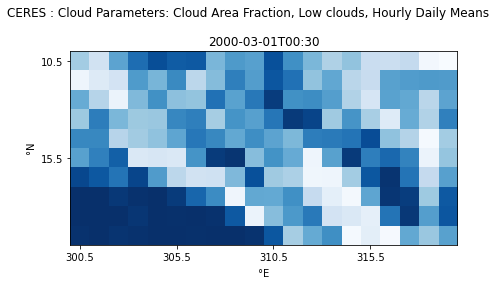

In [130]:
# this is the kind of plot i want to animate
data = ceres
var  = 'lw_net_all'
var  = 'cldarea_low_1h'
cmap = "magma"
cmap = 'Blues'
time = 40

variable = ceres[var].isel(time=time).values # extract values

orig_map=plt.cm.get_cmap(cmap)
cmap = orig_map.reversed()

fig, ax = plt.subplots(figsize=(8,4))
ax.invert_yaxis() # lat values are degrees north

fig.suptitle('CERES : '+ceres[var].long_name)
ax.set_title(ceres.time[0].values.__str__()[0:-13])
ax.set_ylabel('$\degree$N')
ax.set_xlabel('$\degree$E')

tick_res = 5
lon_ticks = ceres.lon.values
lat_ticks = ceres.lat.values
ax.set_xticks(np.arange(0,len(lon_ticks),tick_res))
ax.set_xticklabels(lon_ticks[::tick_res])
ax.set_yticks(np.arange(0,len(lat_ticks),tick_res))
ax.set_yticklabels(lat_ticks[::tick_res])
plt.tight_layout()


ax.imshow(variable, cmap=cmap)



plt.show()

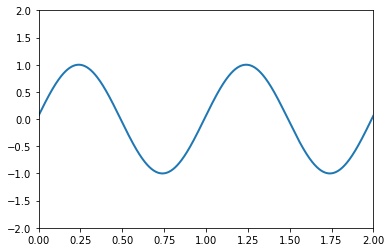

In [11]:
# this is an example of an animated sine
# taken from: http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( 0, 2))
ax.set_ylim((-2, 2))

line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

# animation function. This is called sequentially
def animate(i):
    x = np.linspace(0, 2, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=20, blit=True)

HTML(anim.to_html5_video())

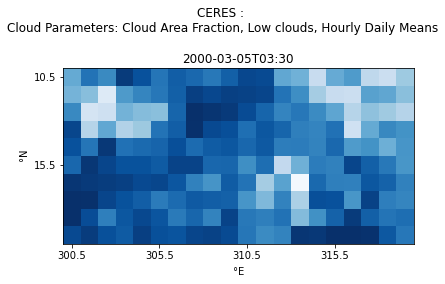

In [134]:
# %matplotlib inline
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib import animation, rc
# from IPython.display import HTML

data = ceres
var  = 'lw_net_all'
var  = 'cldarea_low_1h'
cmap = "magma"
cmap = 'Blues'

orig_map=plt.cm.get_cmap(cmap)
cmap = orig_map.reversed()

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
ax.invert_yaxis() # lat values are degrees north

fig.suptitle('CERES : \n'+ceres[var].long_name)
ax.set_title(ceres.time[0].values.__str__()[0:-13])
ax.set_ylabel('$\degree$N')
ax.set_xlabel('$\degree$E')

tick_res = 5
lon_ticks = ceres.lon.values
lat_ticks = ceres.lat.values
ax.set_xticks(np.arange(0,len(lon_ticks),tick_res))
ax.set_xticklabels(lon_ticks[::tick_res])
ax.set_yticks(np.arange(0,len(lat_ticks),tick_res))
ax.set_yticklabels(lat_ticks[::tick_res])
plt.tight_layout()
# set initial 
variable = ceres[var].isel(time=0).values
radmap = ax.imshow(variable, cmap=cmap)

# initialization function: plot the background of each frame
def init():
    radmap.set_data(variable)     
    return (radmap,)

# animation function. This is called sequentially
def animate(i):
    # x = np.linspace(0, 2, 1000)
    variable = ceres[var].isel(time=i).values
    radmap.set_data(variable)
    ax.set_title(ceres.time[i].values.__str__()[0:-13])
    return (radmap,)

frames = 500
# call the animator. blit=True means only re-draw the parts that have changed.
# full documentation: https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html
anim = animation.FuncAnimation(fig, animate, init_func=init, blit=True,
                               frames=frames,
                               interval=500                               
                              )

HTML(anim.to_html5_video())

In [146]:
# save the video
file_ext  = '.gif'
file_ext  = '.mp4'
file_name = var+'_'+str(frames)+file_ext
anim.save(file_name, fps=2)
print('saved as '+file_name)

saved as cldarea_low_1h_500.mp4


In [147]:
# lets see the video from the file
from IPython.display import Video
Video(file_name)